In [1]:
import os, sys
import numpy as np
sys.path.insert(0, '../fair-classification/disparate_mistreatment/synthetic_data_demo')
sys.path.insert(0, '../fair-classification/fair_classification/')
from generate_synthetic_data import *
import utils as ut
import funcs_disp_mist as fdm
import plot_syn_boundaries as psb
import pandas as pd

In [2]:
def test_synthetic_data():
	
	""" Generate the synthetic data """
	data_type = 1
	X, y, x_control = generate_synthetic_data(data_type=data_type, plot_data=False) # set plot_data to False to skip the data plot
	sensitive_attrs = list(x_control.keys())

	""" Split the data into train and test """
	train_fold_size = 0.5
	x_train, y_train, x_control_train, x_test, y_test, x_control_test = ut.split_into_train_test(X, y, x_control, train_fold_size)

	cons_params = None # constraint parameters, will use them later
	loss_function = "logreg" # perform the experiments with logistic regression
	EPS = 1e-4

	def train_test_classifier():
		w = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)

		train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

		
		# accuracy and FPR are for the test because we need of for plotting
		return w, test_score, s_attr_to_fp_fn_test
		

	""" Classify the data while optimizing for accuracy """
	print()
	print("== Unconstrained (original) classifier ==")
	w_uncons, acc_uncons, s_attr_to_fp_fn_test_uncons = train_test_classifier()
	print("\n-----------------------------------------------------------------------------------\n")

	""" Now classify such that we optimize for accuracy while achieving perfect fairness """
	
	print()
	print( "== Classifier with fairness constraint ==")


	print( "\n\n=== Constraints on FPR ===")	# setting parameter for constraints
	cons_type = 1 # FPR constraint -- just change the cons_type, the rest of parameters should stay the same
	tau = 5.0
	mu = 1.2
	sensitive_attrs_to_cov_thresh = {"s1": {0:{0:0, 1:1e-6}, 1:{0:0, 1:1e-6}, 2:{0:0, 1:1e-6}}} # zero covariance threshold, means try to get the fairest solution
	cons_params = {"cons_type": cons_type, 
					"tau": tau, 
					"mu": mu, 
					"sensitive_attrs_to_cov_thresh": sensitive_attrs_to_cov_thresh}

	w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()
	psb.plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons["s1"], s_attr_to_fp_fn_test_cons["s1"]], "img/syn_cons_dtype_%d_cons_type_%d.png"%(data_type, cons_type) )
	print( "\n-----------------------------------------------------------------------------------\n")

	print( "\n\n=== Constraints on FNR ===")
	cons_type = 2
	cons_params["cons_type"] = cons_type # FNR constraint -- just change the cons_type, the rest of parameters should stay the same
	w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()
	psb.plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons["s1"], s_attr_to_fp_fn_test_cons["s1"]], "img/syn_cons_dtype_%d_cons_type_%d.png"%(data_type, cons_type) )
	print( "\n-----------------------------------------------------------------------------------\n")



	print( "\n\n=== Constraints on both FPR and FNR ===")
	cons_type = 4
	cons_params["cons_type"] = cons_type # both FPR and FNR constraints
	w_cons, acc_cons, s_attr_to_fp_fn_test_cons  = train_test_classifier()
	psb.plot_boundaries(X, y, x_control, [w_uncons, w_cons], [acc_uncons, acc_cons], [s_attr_to_fp_fn_test_uncons["s1"], s_attr_to_fp_fn_test_cons["s1"]], "img/syn_cons_dtype_%d_cons_type_%d.png"%(data_type, cons_type) )
	print( "\n-----------------------------------------------------------------------------------\n")


	return



== Unconstrained (original) classifier ==


Accuracy: 0.821
||  s  || FPR. || FNR. ||
||  0  || 0.27 || 0.23 ||
||  1  || 0.10 || 0.12 ||



-----------------------------------------------------------------------------------


== Classifier with fairness constraint ==


=== Constraints on FPR ===


Accuracy: 0.770
||  s  || FPR. || FNR. ||
||  0  || 0.20 || 0.35 ||
||  1  || 0.21 || 0.16 ||




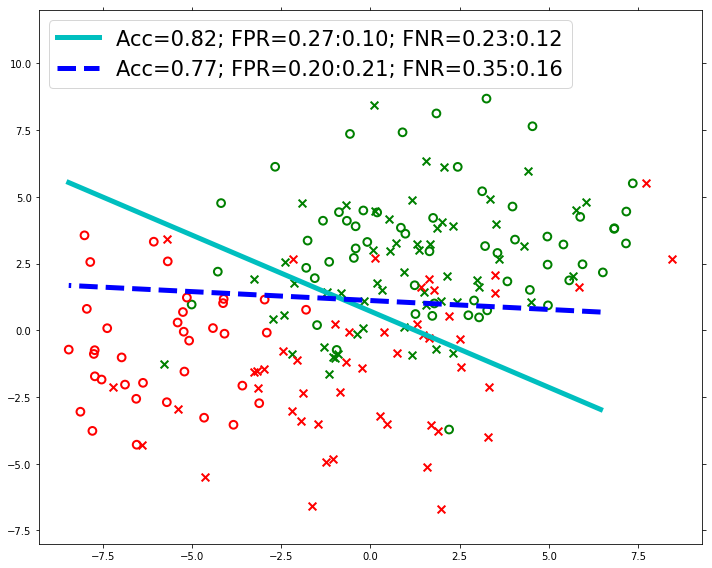


-----------------------------------------------------------------------------------



=== Constraints on FNR ===


Accuracy: 0.775
||  s  || FPR. || FNR. ||
||  0  || 0.61 || 0.12 ||
||  1  || 0.06 || 0.11 ||




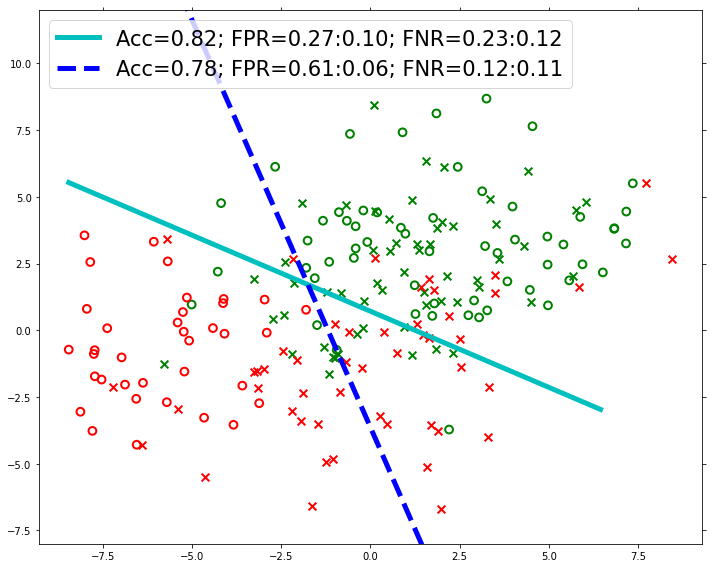


-----------------------------------------------------------------------------------



=== Constraints on both FPR and FNR ===


Accuracy: 0.568
||  s  || FPR. || FNR. ||
||  0  || 0.78 || 0.02 ||
||  1  || 0.90 || 0.00 ||




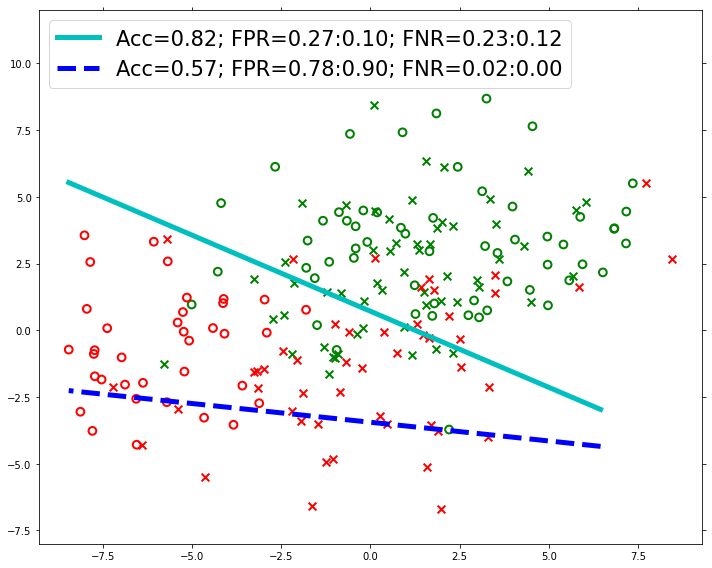


-----------------------------------------------------------------------------------



In [3]:
test_synthetic_data()

## JOCO DATA ORIG TEST

In [4]:
FILE_PATH = '/mnt/data/experiment_data/peeps/joco_zafar/matrices'

label_col = 'booking_view_warr_bw_1y'
white_col = 'protected_demographics_entity_id_all_race_W_max'
demo_col = 'race_2way'
exclude_cols = ['entity_id', 'as_of_date', label_col, demo_col]

def load_matrix(matrix_id):
    df = pd.read_csv('%s/%s.csv.gz' % (FILE_PATH, matrix_id), compression='gzip')
    df[demo_col] = df[white_col]
    df[label_col] = 2*(df[label_col] - 0.5)
    return df

In [5]:
train_matrix_uuid = '4196c476d8a7a3e74923333059d3fb26'
df_train = load_matrix(train_matrix_uuid)
print(pd.value_counts(df_train['race_2way']))
x_train = df_train[[c for c in df_train.columns if c not in exclude_cols]].values
y_train = df_train[label_col].values
x_control_train = {demo_col: df_train[demo_col].values}

1.0    19273
0.0     7292
Name: race_2way, dtype: int64


In [6]:
test_matrix_uuid = '3f46159319b28e87db57f89e993cbdc5'
df_test = load_matrix(test_matrix_uuid)
print(pd.value_counts(df_test['race_2way']))
x_test = df_test[[c for c in df_test.columns if c not in exclude_cols]].values
y_test = df_test[label_col].values
x_control_test = {demo_col: df_test[demo_col].values}

1.0    19081
0.0     7291
Name: race_2way, dtype: int64


In [7]:
print(x_train.shape, df_train.shape)
print(x_test.shape, df_test.shape)

(26565, 3465) (26565, 3469)
(26372, 3465) (26372, 3469)


In [8]:
loss_function = "logreg"
EPS = 1e-4
cons_params = None

def train_test_classifier():
    w = fdm.train_model_disp_mist(x_train, y_train, x_control_train, loss_function, EPS, cons_params)
    train_score, test_score, cov_all_train, cov_all_test, s_attr_to_fp_fn_train, s_attr_to_fp_fn_test = fdm.get_clf_stats(w, x_train, y_train, x_control_train, x_test, y_test, x_control_test, sensitive_attrs)

    # accuracy and FPR are for the test because we need of for plotting
    return w, test_score, s_attr_to_fp_fn_test

In [31]:
cons_params = None
w_uncons, acc_uncons, s_attr_to_fp_fn_test_uncons = train_test_classifier()

Traceback (most recent call last):
  File "../fair-classification/fair_classification/funcs_disp_mist.py", line 109, in train_model_disp_mist
    max_iters=max_iters, max_iter=max_iter_dccp)
  File "/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/cvxpy/problems/problem.py", line 289, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/dccp-1.0.0-py3.6.egg/dccp/problem.py", line 42, in dccp
    result_temp = iter_dccp(self, max_iter, tau, mu, tau_max, solver, ep, max_slack, **kwargs)
  File "/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/dccp-1.0.0-py3.6.egg/dccp/problem.py", line 227, in iter_dccp
    logger.info("iteration=%d, cost value=%.5f, tau=%.5f", it, prob_new.solve(solver=solver, **kwargs), tau)
  File "/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/cvxpy/problems/problem.py", line 289, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/heman

Traceback (most recent call last):
  File "../fair-classification/fair_classification/funcs_disp_mist.py", line 109, in train_model_disp_mist
    max_iters=max_iters, max_iter=max_iter_dccp)
  File "/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/cvxpy/problems/problem.py", line 289, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/dccp-1.0.0-py3.6.egg/dccp/problem.py", line 42, in dccp
    result_temp = iter_dccp(self, max_iter, tau, mu, tau_max, solver, ep, max_slack, **kwargs)
  File "/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/dccp-1.0.0-py3.6.egg/dccp/problem.py", line 227, in iter_dccp
    logger.info("iteration=%d, cost value=%.5f, tau=%.5f", it, prob_new.solve(solver=solver, **kwargs), tau)
  File "/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/cvxpy/problems/problem.py", line 289, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/heman

SystemExit: 1

In [9]:
x = x_train
y = y_train
x_control = x_control_train

max_iters = 150
max_iter_dccp = 75

num_points, num_features = x.shape

import cvxpy

w = cvxpy.Variable(num_features)

np.random.seed(112233)

w.value = np.random.rand(x.shape[1])

constraints = []
loss = cvxpy.sum(  cvxpy.logistic( cvxpy.multiply(-y, x*w) )  ) / num_points
prob = cvxpy.Problem(cvxpy.Minimize(loss), constraints)

tau, mu = 0.005, 1.2

In [10]:
prob.solve(method='dccp', tau=tau, mu=mu, tau_max=1e10, solver=cvxpy.ECOS, verbose=True, 
           feastol=EPS, abstol=EPS, reltol=EPS, feastol_inacc=EPS, abstol_inacc=EPS, reltol_inacc=EPS,
          max_iters=max_iters, max_iter=max_iter_dccp)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -3.449e+04  +2e+05  6e-01  2e+02  1e+00  1e+00    ---    ---    0  0  - |  -  - 
 1  +8.543e-01  -1.912e+04  +1e+05  1e-01  1e+02  6e-01  6e-01  0.5013  2e-01   2  1  2 |  3  3
 2  +1.054e+00  -1.577e+04  +9e+04  1e-01  1e+02  5e-01  5e-01  0.5013  7e-01   2  1  1 |  9  3
 3  +1.115e+00  -1.498e+04  +8e+04  1e-01  1e+02  4e-01  5e-01  0.9791  1e+00   1  2  1 | 18  0
 4  +1.308e+00  -1.185e+04  +7e+04  7e-02  1e+02  4e-01  4e-01  0.5013  6e-01   1  2  1 |  8  3
 5  +1.335e+00  -1.159e+04  +6e+04  6e-02  9e+01  3e-01  3e-01  0.9791  1e+00   1  2  2 | 21  0
 6  +1.491e+00  -9.263e+03  +5e+04  5e-02  7e+01  3e-01  3e-01  0.4010  5e-01   2  1  1 |  7  4
 7  +1.668e+00  -6.944e+03  +4e+04  3e-02  5e+01  2e-01  2e-01  0.5013  5e-01   2  1  1 |  7  3
 8  +1.846e+00  -5.006e+03  +3e+04  2e-02  4e+

84  +2.727e-01  +2.726e-01  +4e-04  7e-11  9e-06  8e-11  2e-09  0.4010  8e-01   1  1  0 | 13  4
85  +2.727e-01  +2.726e-01  +4e-04  7e-11  9e-06  8e-11  2e-09  0.9791  1e+00   2  0  1 | 19  0
86  +2.727e-01  +2.726e-01  +4e-04  6e-11  8e-06  7e-11  2e-09  0.6266  9e-01   2  1  0 | 15  2
87  +2.727e-01  +2.726e-01  +4e-04  6e-11  8e-06  7e-11  2e-09  0.9791  1e+00   2  1  0 | 27  0
88  +2.727e-01  +2.726e-01  +3e-04  6e-11  7e-06  7e-11  2e-09  0.4010  8e-01   2  0  0 | 12  4
89  +2.727e-01  +2.726e-01  +3e-04  6e-11  7e-06  6e-11  2e-09  0.9791  1e+00   2  1  0 | 24  0
90  +2.727e-01  +2.726e-01  +3e-04  5e-11  7e-06  6e-11  2e-09  0.4010  8e-01   2  0  0 | 13  4
91  +2.727e-01  +2.726e-01  +3e-04  5e-11  7e-06  6e-11  2e-09  0.9791  1e+00   2  1  1 | 24  0
92  +2.727e-01  +2.726e-01  +3e-04  5e-11  6e-06  6e-11  1e-09  0.4010  8e-01   2  0  0 | 13  4
93  +2.727e-01  +2.726e-01  +3e-04  5e-11  6e-06  6e-11  1e-09  0.9791  1e+00   1  1  1 | 25  0
94  +2.727e-01  +2.726e-01  +3e-04  5e-1

45  +2.728e-01  +2.725e-01  +7e-03  1e-09  1e-04  1e-09  4e-08  0.9791  9e-01   2  1  1 | 14  0
46  +2.728e-01  +2.726e-01  +5e-03  9e-10  1e-04  1e-09  3e-08  0.4010  6e-01   2  1  1 |  8  4
47  +2.728e-01  +2.726e-01  +5e-03  8e-10  1e-04  9e-10  3e-08  0.9791  9e-01   2  1  1 | 15  0
48  +2.728e-01  +2.726e-01  +4e-03  7e-10  9e-05  8e-10  2e-08  0.5013  8e-01   1  1  1 | 11  3
49  +2.728e-01  +2.726e-01  +4e-03  7e-10  8e-05  8e-10  2e-08  0.9791  9e-01   2  1  1 | 17  0
50  +2.727e-01  +2.726e-01  +4e-03  6e-10  8e-05  7e-10  2e-08  0.4010  7e-01   1  1  1 | 10  4
51  +2.727e-01  +2.726e-01  +3e-03  5e-10  7e-05  6e-10  2e-08  0.9791  9e-01   2  1  1 | 16  0
52  +2.727e-01  +2.726e-01  +3e-03  5e-10  6e-05  6e-10  2e-08  0.5013  8e-01   2  0  0 | 11  3
53  +2.727e-01  +2.726e-01  +3e-03  5e-10  6e-05  6e-10  2e-08  0.9791  1e+00   2  1  0 | 26  0
54  +2.727e-01  +2.726e-01  +2e-03  4e-10  5e-05  5e-10  1e-08  0.4010  7e-01   2  0  0 |  9  4
55  +2.727e-01  +2.726e-01  +2e-03  4e-1

(0.27265333337753167,
 [array([ -0.48815884,   1.38243319,   0.1540649 , ...,   0.6057178 ,
         -24.14806953,   4.56856309])])